In [14]:
# written in python 3
# Yicheng Li
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_pickle('BTC-USD-60.pkl')

In [3]:
df['date'] = pd.to_datetime(df['time'],unit='s').dt.date

In [4]:
group = df.groupby('date')
Daily_Mean_Price = group['close'].mean()

Daily_Mean_Price.head()

date
2016-01-01    433.300405
2016-01-02    435.083883
2016-01-03    431.338427
2016-01-04    433.626442
2016-01-05    433.373114
Name: close, dtype: float64

In [5]:
Daily_Mean_Price=Daily_Mean_Price.reset_index()
Daily_Mean_Price=Daily_Mean_Price.set_index('date')

# Prepare data as np array

In [27]:
df2 = Daily_Mean_Price
df2['label'] = df2['close'].shift(-1)

# std_scale = preprocessing.StandardScaler().fit(Daily_Mean_Price)
# Daily_Mean_Price = std_scale.transform(Daily_Mean_Price)
# Daily_Mean_Price = Daily_Mean_Price + 1 - min(Daily_Mean_Price)
# Daily_Mean_Price = pd.DataFrame(Daily_Mean_Price)

In [29]:
df2.head()

,close,label
date,,
2016-01-01,433.300405,435.083883
2016-01-02,435.083883,431.338427
2016-01-03,431.338427,433.626442
2016-01-04,433.626442,433.373114
2016-01-05,433.373114,431.927898


In [30]:
X = np.array(df2.drop(['label'], 1))
y = np.array(df2['label'])
X = X[:-1]
y = y[:-1]

In [31]:
#Standardize feature data
X = preprocessing.scale(X)

# Autocorrelation

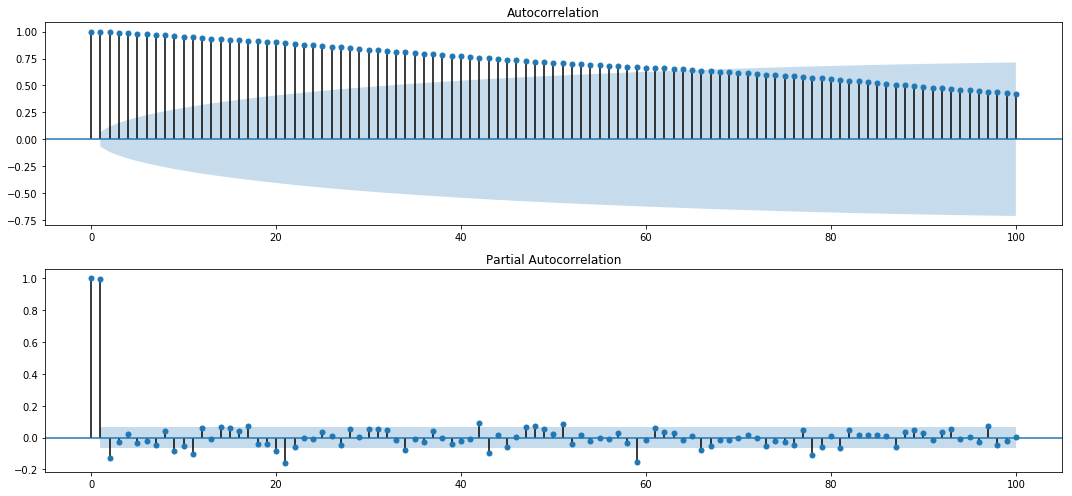

In [33]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(Daily_Mean_Price.close.values.squeeze(), lags=100, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(Daily_Mean_Price.close.values.squeeze(), lags=100, ax=ax)
plt.tight_layout()
plt.show()

# Define evaluation metrics

In [9]:
def RMSE(y, y_pred):
    if len(y) != len(y_pred):
        raise ValueError('Length of prediction array is not equal to length of y array.')
    return np.sqrt(sum((y_pred-y)**2)/len(y))

In [10]:
def SMAPE(y, y_pred):
    if len(y) != len(y_pred):
        raise ValueError('Length of prediction array is not equal to length of y array.')
    return np.mean(np.abs(y-y_pred)*2/(np.abs(y)+np.abs(y_pred)))

In [14]:
def normalized_RMSE(y, y_pred):
    if len(y) != len(y_pred):
        raise ValueError('Length of prediction array is not equal to length of y array.')
    return np.sqrt(sum((y_pred/y-1)**2)/len(y))

In [15]:
def RMSE_log_price(y, y_pred):
    if len(y) != len(y_pred):
        raise ValueError('Length of prediction array is not equal to length of y array.')
    return np.sqrt(sum((np.log(y_pred)-np.log(y))**2)/len(y))

In [64]:
validate_with_window_size(window_size=1, W=np.array([1]), b=0) # Wensi Yin's baseline with window size = 1

Validation SMAPE: 0.035047209389751824


# Prepare data again to include a window of past prices as feature

In [32]:
X_new = X.copy()
for shift in range(1,20):
    X_new = np.concatenate([X_new, \
                           np.pad(X,((shift,0),(0,0)), mode='constant',constant_values=np.nan)[:-shift]]\
                           , axis = 1)

In [71]:
np.isnan(X_new[:,-1]).sum()

19

In [35]:
X_new = X_new[:][19:]
y = y[19:]

In [73]:
np.isnan(X_new[:,-1]).sum()

0

In [36]:
X_train, X_test, y_train, y_test \
    = train_test_split(X_new, y, test_size=0.2)

X_train, X_val, y_train, y_val \
    = train_test_split(X_train, y_train, test_size=0.2)

### Linear regression with different window sizes

In [37]:
linear_reg = LinearRegression()

for window_size in range(1,21):
    linear_reg.fit(X_train[:,:window_size], y_train)
    y_pred = linear_reg.predict(X_val[:,:window_size])
    print('window_size=',window_size,'SMAPE=',SMAPE(y_val, y_pred))

window_size= 1 SMAPE= 0.03398454831237503
window_size= 2 SMAPE= 0.03158044395975198
window_size= 3 SMAPE= 0.03139929620512934
window_size= 4 SMAPE= 0.03140976265388537
window_size= 5 SMAPE= 0.03217622460902219
window_size= 6 SMAPE= 0.0318942994523338
window_size= 7 SMAPE= 0.03263050876161087
window_size= 8 SMAPE= 0.03254462696062404
window_size= 9 SMAPE= 0.033065162327424825
window_size= 10 SMAPE= 0.03325389678838915
window_size= 11 SMAPE= 0.03309855914490728
window_size= 12 SMAPE= 0.033444887821337116
window_size= 13 SMAPE= 0.03354973569995548
window_size= 14 SMAPE= 0.033420322664364385
window_size= 15 SMAPE= 0.03336211788170603
window_size= 16 SMAPE= 0.03384511533999684
window_size= 17 SMAPE= 0.03336933720837856
window_size= 18 SMAPE= 0.03359624189244507
window_size= 19 SMAPE= 0.033622826242492354
window_size= 20 SMAPE= 0.03353935682581939


### Ridge regression

In [38]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.5)
for window_size in range(1,21):
    ridge.fit(X_train[:,:window_size], y_train)
    y_pred = ridge.predict(X_val[:,:window_size])
    print('window_size=',window_size,'SMAPE=',SMAPE(y_val, y_pred))

window_size= 1 SMAPE= 0.03604200373219756
window_size= 2 SMAPE= 0.03598323729956695
window_size= 3 SMAPE= 0.03622284356011346
window_size= 4 SMAPE= 0.03625115228071768
window_size= 5 SMAPE= 0.03678560533921237
window_size= 6 SMAPE= 0.036756241442162364
window_size= 7 SMAPE= 0.03727374878989818
window_size= 8 SMAPE= 0.037205486998688544
window_size= 9 SMAPE= 0.037557955185842415
window_size= 10 SMAPE= 0.03794829437925814
window_size= 11 SMAPE= 0.03799178274896077
window_size= 12 SMAPE= 0.03814022015785319
window_size= 13 SMAPE= 0.03816614012557572
window_size= 14 SMAPE= 0.0378740769792284
window_size= 15 SMAPE= 0.03758458645821509
window_size= 16 SMAPE= 0.037978129150294374
window_size= 17 SMAPE= 0.037861818808801566
window_size= 18 SMAPE= 0.03785910355900544
window_size= 19 SMAPE= 0.03803419073635502
window_size= 20 SMAPE= 0.038175470949975004


### Lasso Regression

In [39]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1, max_iter=10000)
for window_size in range(1,21):
    lasso.fit(X_train[:,:window_size], y_train)
    y_pred = lasso.predict(X_val[:,:window_size])
    print('window_size=',window_size,'SMAPE=',SMAPE(y_val, y_pred))

window_size= 1 SMAPE= 0.03450122762210335
window_size= 2 SMAPE= 0.03345844286123296
window_size= 3 SMAPE= 0.03370309812350254
window_size= 4 SMAPE= 0.033703327190357166
window_size= 5 SMAPE= 0.03474998391247217
window_size= 6 SMAPE= 0.03474998391247217
window_size= 7 SMAPE= 0.03508245611812358
window_size= 8 SMAPE= 0.03508245611812358
window_size= 9 SMAPE= 0.03516086386314578
window_size= 10 SMAPE= 0.03538633946366873
window_size= 11 SMAPE= 0.03576186326963768
window_size= 12 SMAPE= 0.03576186326963768
window_size= 13 SMAPE= 0.03590373017179227
window_size= 14 SMAPE= 0.0358544375074576
window_size= 15 SMAPE= 0.03566435936461639
window_size= 16 SMAPE= 0.03580543464463681
window_size= 17 SMAPE= 0.03579666788002234
window_size= 18 SMAPE= 0.035797912428275146
window_size= 19 SMAPE= 0.035797912428275146
window_size= 20 SMAPE= 0.035801617753075006
